<a href="https://colab.research.google.com/github/crowell97/ES2245/blob/main/es2245_lecture3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

# Set plot style for better visuals
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

## 4.1 Accuracy vs. Precision
We simulate measurements taken against a known standard (True Value = 0,0).
* **Precision:** Controlled by standard deviation (spread).
* **Accuracy:** Controlled by the mean (offset from 0,0).

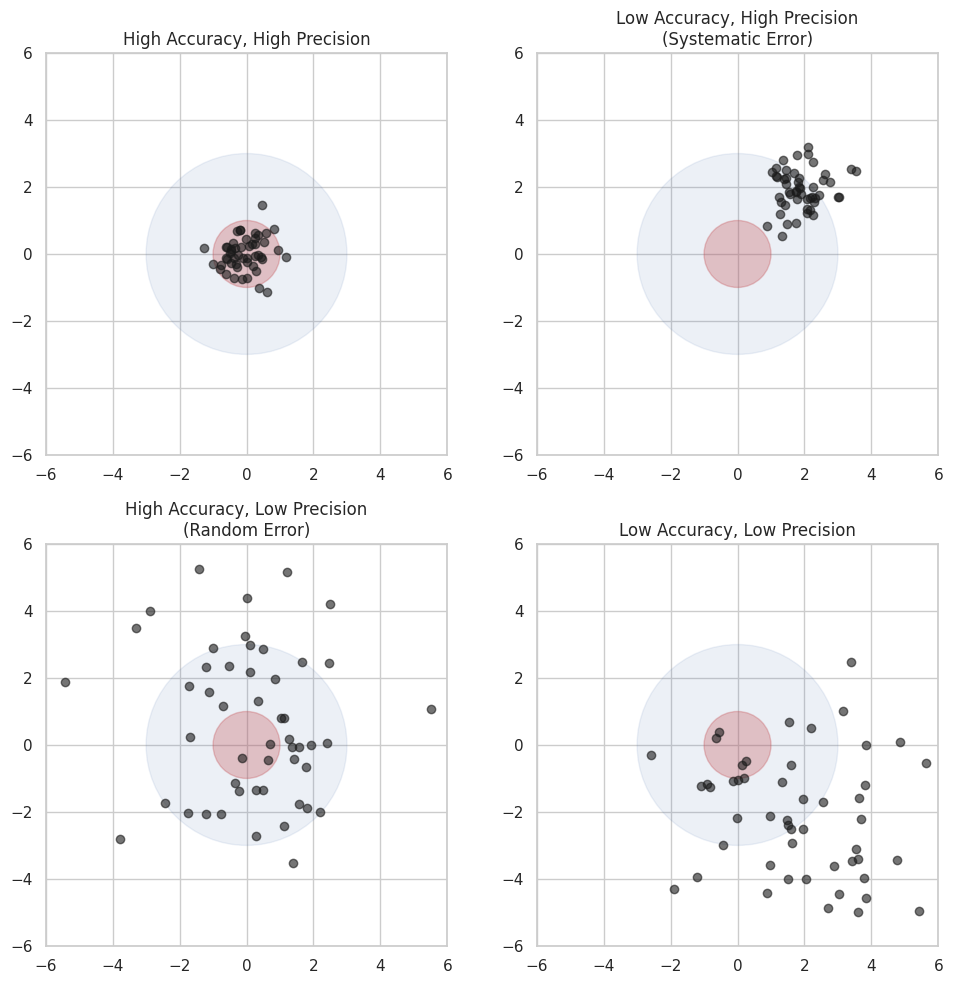

In [2]:
def plot_target(ax, title, x_offset, y_offset, spread):
    # Generate 50 random 'shots'
    x = np.random.normal(x_offset, spread, 50)
    y = np.random.normal(y_offset, spread, 50)

    # Draw the target bullseye
    circle1 = plt.Circle((0, 0), 1, color='r', alpha=0.3)
    circle2 = plt.Circle((0, 0), 3, color='b', alpha=0.1)
    ax.add_patch(circle2)
    ax.add_patch(circle1)

    # Plot shots
    ax.scatter(x, y, color='k', alpha=0.6)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.set_title(title)
    ax.set_aspect('equal')

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# 1. High Accuracy, High Precision (On target, tight cluster)
plot_target(axes[0,0], "High Accuracy, High Precision", 0, 0, 0.5)

# 2. Low Accuracy, High Precision (Off target, tight cluster)
plot_target(axes[0,1], "Low Accuracy, High Precision\n(Systematic Error)", 2, 2, 0.5)

# 3. High Accuracy, Low Precision (On target, scattered)
plot_target(axes[1,0], "High Accuracy, Low Precision\n(Random Error)", 0, 0, 2.0)

# 4. Low Accuracy, Low Precision (Off target, scattered)
plot_target(axes[1,1], "Low Accuracy, Low Precision", 2, -2, 2.0)

plt.tight_layout()
plt.show()

## 4.2 Pseudoreplication (The "Plowed Field" Problem)
**Scenario:** A natural gradient of Nickel exists in the soil (Higher in the North, Lower in the South).
**Experiment:** We plow the North half (Field A) and leave the South half unplowed (Field B).
**Error:** We take 100 samples from A and 100 from B.

/tmp/ipython-input-2636524304.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot([sample_A, sample_B], labels=['Plowed (North)', 'Unplowed (South)'])


Conclusion: The test is highly significant (p=6.626453307577197e-70), but it detects the LOCATION difference, not the PLOWING effect.


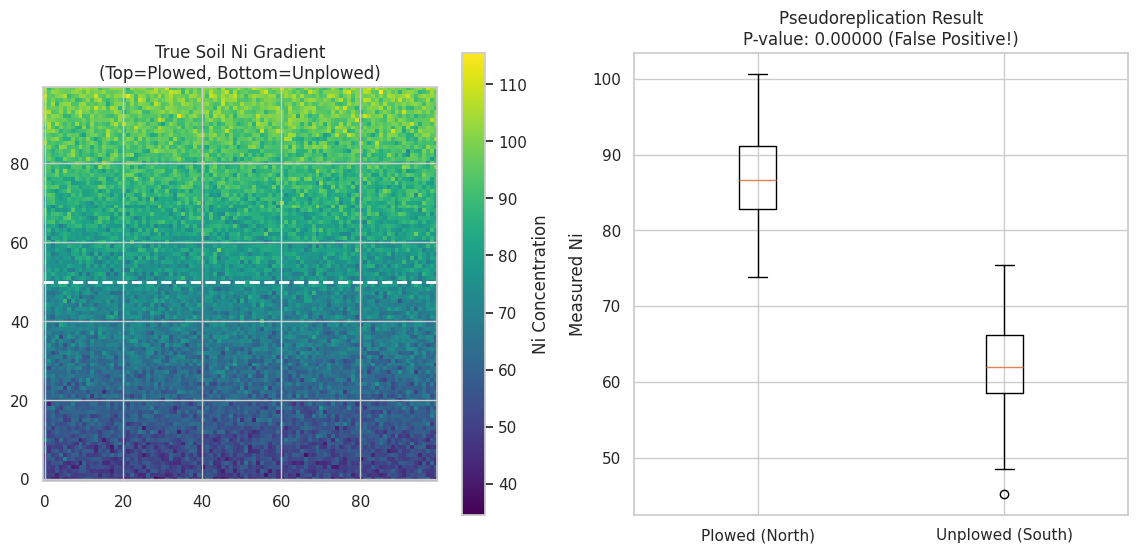

In [3]:
# Create a spatial gradient (Natural variation: North is high Ni, South is low Ni)
# 100x100 grid representing the land
x = np.linspace(0, 100, 100)
y = np.linspace(0, 100, 100)
X, Y = np.meshgrid(x, y)

# True Nickel concentration depends on Y (Latitude), NOT on plowing
# High nickel at Y=100 (North), Low at Y=0 (South)
true_Ni = 50 + (0.5 * Y) + np.random.normal(0, 5, (100,100)) # Add some random noise

# --- The Bad Design (Pseudoreplication) ---
# We "Plow" the top half (Rows 50-99) and leave bottom half unplowed (Rows 0-49)
# We sample 100 points from the Plowed area and 100 from Unplowed
plowed_samples = true_Ni[60:90, 20:80].flatten() # Sample from North
unplowed_samples = true_Ni[10:40, 20:80].flatten() # Sample from South

# Randomly select 100 measurements from these areas
sample_A = np.random.choice(plowed_samples, 100)
sample_B = np.random.choice(unplowed_samples, 100)

# Statistics
t_stat, p_val = stats.ttest_ind(sample_A, sample_B)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Map
im = ax[0].imshow(true_Ni, origin='lower', cmap='viridis')
ax[0].set_title(f"True Soil Ni Gradient\n(Top=Plowed, Bottom=Unplowed)")
ax[0].axhline(50, color='white', linestyle='--', linewidth=2, label="Field Boundary")
plt.colorbar(im, ax=ax[0], label="Ni Concentration")

# Results boxplot
ax[1].boxplot([sample_A, sample_B], labels=['Plowed (North)', 'Unplowed (South)'])
ax[1].set_title(f"Pseudoreplication Result\nP-value: {p_val:.5f} (False Positive!)")
ax[1].set_ylabel("Measured Ni")

print(f"Conclusion: The test is highly significant (p={p_val}), but it detects the LOCATION difference, not the PLOWING effect.")
plt.show()

## 4.3 Randomization and Interspersion
**Scenario:** A lab bench has a temperature gradient (Warmer on the right).
**Experiment:** Testing a chemical reaction rate (sensitive to heat).
**Bad Design:** All Treatments on the right, Controls on the left.
**Good Design:** Randomized positions.

True Treatment Effect is +5.0
Segregated Design estimates: 14.15 (Overestimated due to heat)
Randomized Design estimates: 2.30 (Closer to truth)


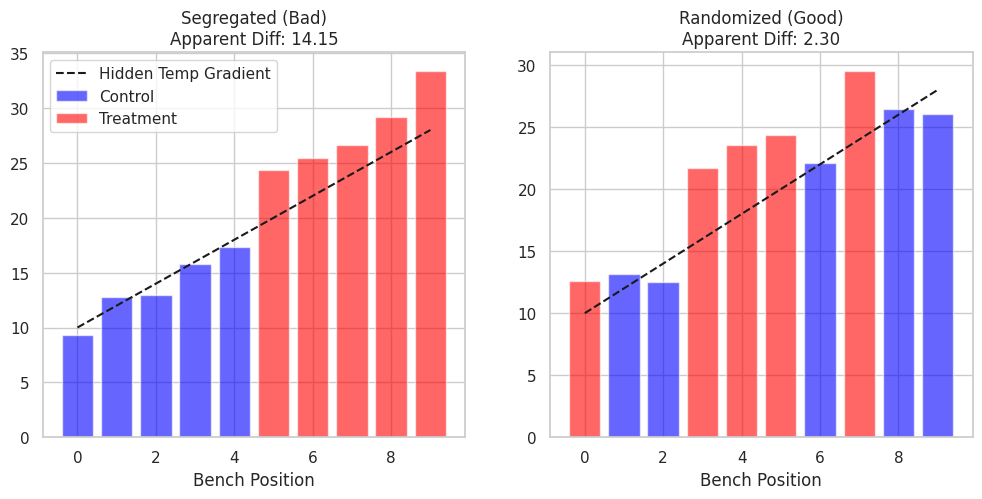

In [4]:
# Create a Lab Bench (10 spots)
bench_positions = np.arange(10)
# Hidden variable: Temperature increases from left to right
temperature_effect = bench_positions * 2

# True effect of treatment (e.g., adds +5 to rate)
treatment_effect = 5

# --- Scenario 1: Segregated (Bad Design) ---
# Controls at 0-4, Treatments at 5-9
ctrl_pos_bad = np.arange(5)
trt_pos_bad = np.arange(5, 10)

# Observed Rate = Base + Temp Effect + Treatment Effect + Noise
ctrl_val_bad = 10 + temperature_effect[ctrl_pos_bad] + 0 + np.random.normal(0,1,5)
trt_val_bad = 10 + temperature_effect[trt_pos_bad] + treatment_effect + np.random.normal(0,1,5)

# --- Scenario 2: Randomized (Good Design) ---
all_pos = np.arange(10)
np.random.shuffle(all_pos)
ctrl_pos_good = all_pos[:5]
trt_pos_good = all_pos[5:]

ctrl_val_good = 10 + temperature_effect[ctrl_pos_good] + 0 + np.random.normal(0,1,5)
trt_val_good = 10 + temperature_effect[trt_pos_good] + treatment_effect + np.random.normal(0,1,5)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Bad Design
ax1.bar(ctrl_pos_bad, ctrl_val_bad, color='blue', label='Control', alpha=0.6)
ax1.bar(trt_pos_bad, trt_val_bad, color='red', label='Treatment', alpha=0.6)
ax1.plot(bench_positions, 10 + temperature_effect, 'k--', label='Hidden Temp Gradient')
ax1.set_title(f"Segregated (Bad)\nApparent Diff: {np.mean(trt_val_bad)-np.mean(ctrl_val_bad):.2f}")
ax1.set_xlabel("Bench Position")
ax1.legend()

# Plot Good Design
ax2.bar(ctrl_pos_good, ctrl_val_good, color='blue', label='Control', alpha=0.6)
ax2.bar(trt_pos_good, trt_val_good, color='red', label='Treatment', alpha=0.6)
ax2.plot(bench_positions, 10 + temperature_effect, 'k--', label='Hidden Temp Gradient')
ax2.set_title(f"Randomized (Good)\nApparent Diff: {np.mean(trt_val_good)-np.mean(ctrl_val_good):.2f}")
ax2.set_xlabel("Bench Position")

print(f"True Treatment Effect is +5.0")
print(f"Segregated Design estimates: {np.mean(trt_val_bad)-np.mean(ctrl_val_bad):.2f} (Overestimated due to heat)")
print(f"Randomized Design estimates: {np.mean(trt_val_good)-np.mean(ctrl_val_good):.2f} (Closer to truth)")
plt.show()

## 4.4 Unreplicated Experiments (BACI Design)
When N=1 (e.g., one lake), we use time-series data.
**Scenario:** A factory opens at Time=50.
**Impact Site:** Pollution increases after T=50.
**Control Site:** Pollution remains natural (seasonal).

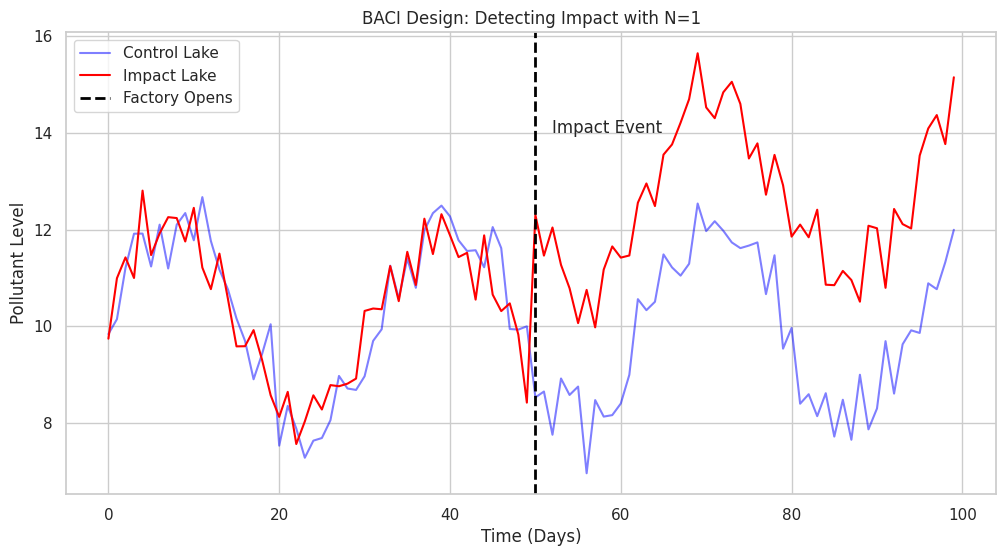

In [5]:
# Generate Time Series
time = np.arange(0, 100)
# Seasonal variation (sine wave) shared by both sites
seasonality = np.sin(time / 5) * 2

# Control Site: Seasonality + Random Noise
control_site = 10 + seasonality + np.random.normal(0, 0.5, 100)

# Impact Site: Seasonality + Random Noise + IMPACT after t=50
impact = np.zeros(100)
impact[50:] = 3.0 # The factory adds 3 units of pollution
impact_site = 10 + seasonality + impact + np.random.normal(0, 0.5, 100)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time, control_site, label='Control Lake', color='blue', alpha=0.5)
plt.plot(time, impact_site, label='Impact Lake', color='red')

# Add impact line
plt.axvline(x=50, color='black', linestyle='--', linewidth=2, label='Factory Opens')
plt.text(52, 14, "Impact Event", fontsize=12)

plt.title("BACI Design: Detecting Impact with N=1")
plt.xlabel("Time (Days)")
plt.ylabel("Pollutant Level")
plt.legend()
plt.show()

## Part 5: Realism in Experiments (Section 4.5)

**The Concept:**
A statistically perfect experiment is useless if the conditions do not match geological reality.
* **The Example:** Early experiments on olivine crystals found no temperature effect on growth rates.
* **The Flaw:** They were conducted at 1000°C (easy for ovens).
* **The Reality:** Crustal magmas are 1300°C–1500°C. When tested at *real* temperatures, a clear effect was found.
* **The Visualization:** We plot the "Validity Gap" between what is easy to measure in the lab and what actually happens in the mantle.

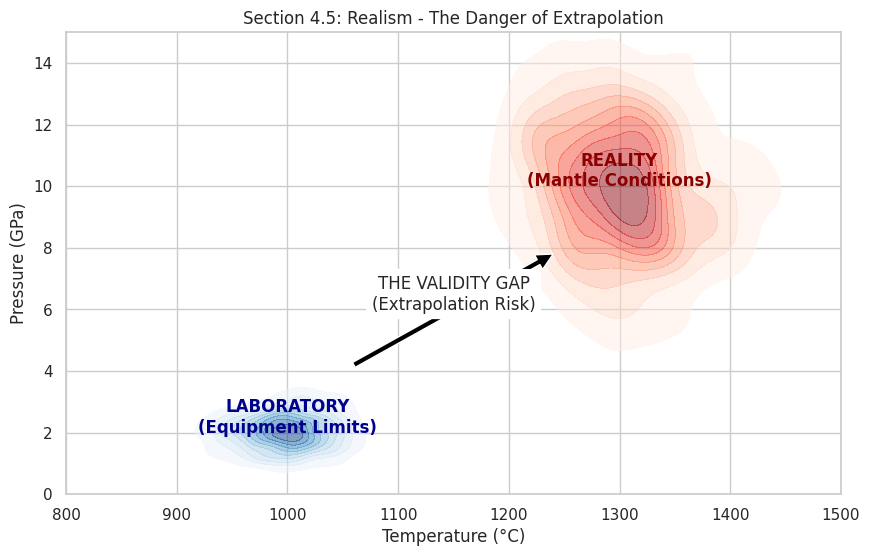

Lesson: If your lab data (Blue) doesn't overlap with nature (Red), your statistical p-value is irrelevant.


In [6]:
# Create a "Parameter Space" plot
plt.figure(figsize=(10, 6))

# 1. Define the Real World Conditions (e.g., Mantle Temperature & Pressure)
# High Temp (1200-1400), High Pressure
real_temp = np.random.normal(1300, 50, 500)
real_pres = np.random.normal(10, 2, 500)
sns.kdeplot(x=real_temp, y=real_pres, fill=True, cmap="Reds", alpha=0.5, label='Geological Reality')
plt.text(1300, 10, "REALITY\n(Mantle Conditions)", color='darkred', ha='center', fontweight='bold')

# 2. Define the "Easy" Lab Conditions (e.g., Standard Ovens)
# Lower Temp (limited by equipment), Lower Pressure
lab_temp = np.random.normal(1000, 30, 500)
lab_pres = np.random.normal(2, 0.5, 500)
sns.kdeplot(x=lab_temp, y=lab_pres, fill=True, cmap="Blues", alpha=0.5, label='Lab Capability')
plt.text(1000, 2, "LABORATORY\n(Equipment Limits)", color='darkblue', ha='center', fontweight='bold')

# 3. Annotate the problem
plt.annotate('', xy=(1250, 8), xytext=(1050, 4),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.text(1150, 6, "THE VALIDITY GAP\n(Extrapolation Risk)", ha='center', bbox=dict(boxstyle="round", fc="white"))

plt.title("Section 4.5: Realism - The Danger of Extrapolation")
plt.xlabel("Temperature (°C)")
plt.ylabel("Pressure (GPa)")
plt.xlim(800, 1500)
plt.ylim(0, 15)
plt.show()

print("Lesson: If your lab data (Blue) doesn't overlap with nature (Red), your statistical p-value is irrelevant.")

## Part 6: A Bit of Common Sense (Section 4.6)

**The Concept:**
Statistics are a tool, not a replacement for looking at your data. A single data entry error ("outlier") can ruin a perfectly designed experiment if you blindly trust the calculated Mean and P-value.

**Simulation:**
We generate a dataset of rock densities. We introduce **one** typo (a decimal error). We see how the **Mean** is destroyed while the **Median** remains robust.

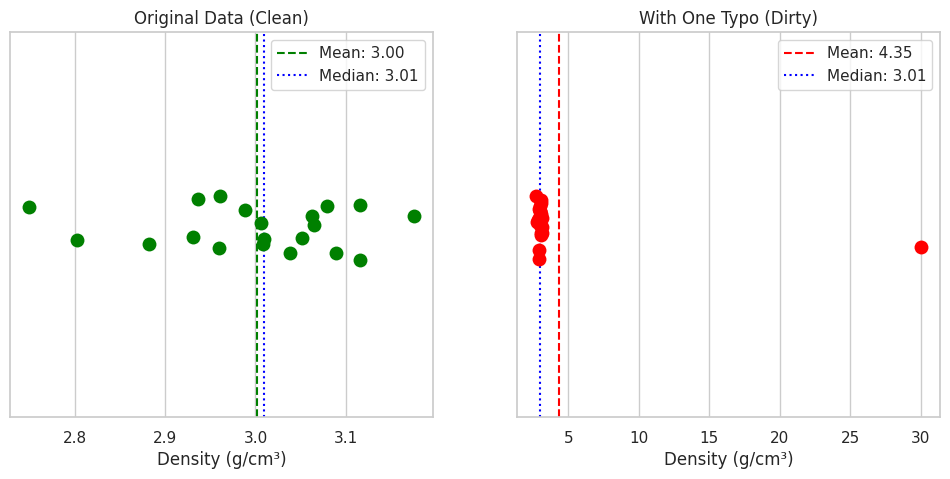

Effect of ONE typo:
Mean shifted from 3.00 -> 4.35 (Massive Error!)
Median shifted from 3.01 -> 3.01 (Robust)
Lesson: Always graph your data before running a test.


In [7]:
# 1. Generate clean data (Density of Basalt, approx 3.0 g/cm3)
data_clean = np.random.normal(3.0, 0.1, 20)

# 2. Create "Dirty" data with ONE typo (30.0 instead of 3.0)
data_dirty = data_clean.copy()
data_dirty[-1] = 30.0  # The error

# 3. Calculate Stats
mean_clean = np.mean(data_clean)
median_clean = np.median(data_clean)

mean_dirty = np.mean(data_dirty)
median_dirty = np.median(data_dirty)

# 4. Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Clean
sns.stripplot(x=data_clean, ax=ax1, color='green', size=10, jitter=True)
ax1.axvline(mean_clean, color='green', linestyle='--', label=f'Mean: {mean_clean:.2f}')
ax1.axvline(median_clean, color='blue', linestyle=':', label=f'Median: {median_clean:.2f}')
ax1.set_title("Original Data (Clean)")
ax1.set_xlabel("Density (g/cm³)")
ax1.legend()

# Plot Dirty
sns.stripplot(x=data_dirty, ax=ax2, color='red', size=10, jitter=True)
ax2.axvline(mean_dirty, color='red', linestyle='--', label=f'Mean: {mean_dirty:.2f}')
ax2.axvline(median_dirty, color='blue', linestyle=':', label=f'Median: {median_dirty:.2f}')
ax2.set_title("With One Typo (Dirty)")
ax2.set_xlabel("Density (g/cm³)")
ax2.legend()

plt.show()

print(f"Effect of ONE typo:")
print(f"Mean shifted from {mean_clean:.2f} -> {mean_dirty:.2f} (Massive Error!)")
print(f"Median shifted from {median_clean:.2f} -> {median_dirty:.2f} (Robust)")
print("Lesson: Always graph your data before running a test.")

## Part 7: Designing a "Good" Experiment (Section 4.7)

**The Trade-off:**
There is no such thing as a "perfect" experiment.
* **Scientific Rigor:** Increases with complexity (more replicates, more controls, better instruments).
* **Feasibility:** Decreases with complexity (costs rise, time runs out).
* **The Goal:** Find the "Sweet Spot" where the design is good enough to answer the question without being impossible to perform.

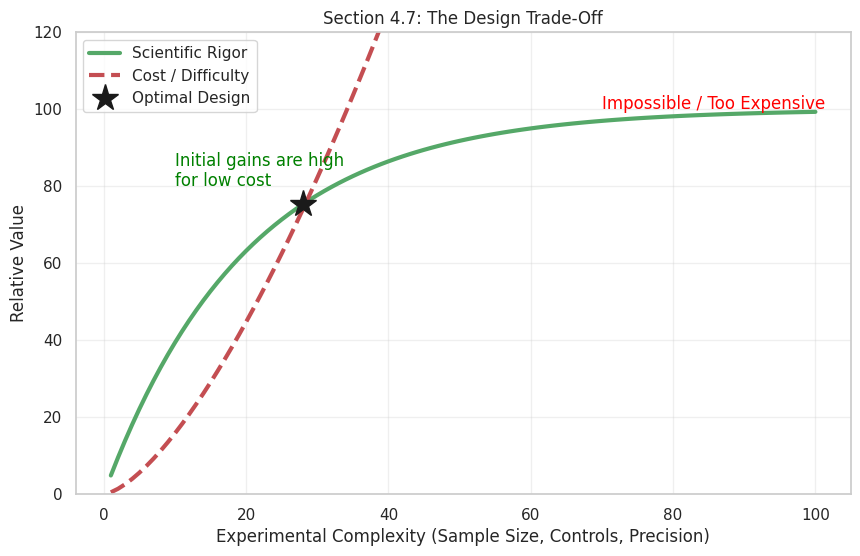

In [8]:
# Define the complexity scale (0 to 100)
complexity = np.linspace(1, 100, 100)

# 1. Scientific Value (Diminishing returns)
# At first, adding replicates helps a lot. Eventually, it adds very little value.
scientific_value = 100 * (1 - np.exp(-0.05 * complexity))

# 2. Cost / Difficulty (Exponential Increase)
# Doing 10 samples is cheap. Doing 1000 is astronomically expensive.
cost = 0.5 * complexity**1.5

# Plotting the Trade-off (Recreating Figure 4.6 concepts)
plt.figure(figsize=(10, 6))

plt.plot(complexity, scientific_value, 'g-', linewidth=3, label='Scientific Rigor')
plt.plot(complexity, cost, 'r--', linewidth=3, label='Cost / Difficulty')

# Highlight the "Sweet Spot" (Intersection or max gap)
# Just visually estimating the crossing point for the chart
crossing_idx = np.argwhere(np.diff(np.sign(scientific_value - cost))).flatten()
if len(crossing_idx) > 0:
    plt.plot(complexity[crossing_idx], scientific_value[crossing_idx], 'k*', markersize=20, label='Optimal Design')

plt.title("Section 4.7: The Design Trade-Off")
plt.xlabel("Experimental Complexity (Sample Size, Controls, Precision)")
plt.ylabel("Relative Value")
plt.ylim(0, 120)
plt.legend()
plt.grid(True, alpha=0.3)

plt.text(10, 80, "Initial gains are high\nfor low cost", color='green')
plt.text(70, 100, "Impossible / Too Expensive", color='red')

plt.show()

## Conclusion (Section 4.8)

**Chapter 4 Summary:**
1.  **Precision $\neq$ Accuracy:** You can be precisely wrong.
2.  **Independence is Key:** Do not confuse subsamples with replicates (Pseudoreplication).
3.  **Randomize:** Use randomness to break the link between hidden variables and your treatment.
4.  **Be Real:** Ensure your lab conditions reflect the geological reality.
5.  **Be Practical:** The best design is the one that is rigorous enough to be valid, but simple enough to actually finish.